# Single server

This example is from Choi, Kang: Modeling and Simulation of Discrete-Event Systems, p. 18. It describes a single server system. The event graph given is:

![single server](../src/images/sserver.svg)

1. Initially there are no jobs in the queue $Q$ and the machine $M$ is idle.
2. Jobs arrive with an inter-arrival-time $t_a$ and are added to $Q$.
3. If $M$ is idle, it loads a job, changes to busy and executes the job with service time $t_s$.
4. After that it unloads the job, changes to idle and, if $Q$ is not empty, it loads the next job.

## Implementing it 

We use this simple example for illustration of how it can be modeled, simulated and analyzed using `Simulate.jl`. First we have to import the necessary modules:

In [1]:
using Simulate, Random, Distributions, DataFrames, Plots, LaTeXStrings, Unitful
import Unitful: minute
pyplot()

Plots.PyPlotBackend()

We have to define some data structures, variables and a function for collecting stats:

In [2]:
abstract type MState end

struct Idle <: MState end
struct Busy <: MState end

mutable struct Job
    no::Int64
    ts::Float64
    t1::Float64
    t2::Float64
    t3::Float64
end

mutable struct Machine
    state::MState
    job
end

Q = Job[]   # input queue
S = Job[]   # stock
M = Machine(Idle(), 0)
df = DataFrame(time = Float64[], buffer=Int[], machine=Int[], finished=Int[])
count = 1
printing = true

stats() = push!(df, (τ().val, length(Q), M.state == Busy() ? 1 : 0, length(S)))

stats (generic function with 1 method)

We can model our system **activity-based** und therefore implement functions for the three main activities (arrive, load, unload), which call each other during simulation. 

We use the arrival-function for modeling arrival rate $t_a$ with an Erlang and service time $t_s$ with a Normal distribution. We determine the capacity of the server with a $c$ variable such that $c > 1$ gives us overcapacity and $c = 1$ means that mean service time equals mean arrival rate $\bar{t_s} = \bar{t_a}$.

In [3]:
function arrive(μ, σ, c)
    @assert μ ≥ 1 "μ must be ≥ 1"
    ts = rand(Normal(μ, σ))/c
    job = Job(count, ts, τ().val, 0, 0)
    global count += 1
    push!(Q, job)
    ta = rand(Erlang())*μ
    event!(𝐶, SimFunction(arrive, μ, σ, c), after, ta)  # we schedule the next arrival
    printing ? println(τ(), ": job $(job.no) has arrived") : nothing # τ() is the current time
    if M.state == Idle()
        load()
    else
        stats()
    end
end

function load()
    M.state = Busy()
    M.job = popfirst!(Q)
    M.job.t2 = τ().val
    event!(𝐶, SimFunction(unload), after, M.job.ts)  # we schedule the unload
    printing ? println(τ(), ": job $(M.job.no) has been loaded") : nothing
    stats()
end

function unload()
    M.state = Idle()
    M.job.t3 = τ().val
    push!(S, M.job)
    printing ? println(τ(), ": job $(M.job.no) has been finished") : nothing
    stats()
    M.job = 0
    if !isempty(Q)
        load()
    end
end

unload (generic function with 1 method)

We want to collect `stats()` at a sample rate of 0.1:  

In [4]:
setUnit!(𝐶, minute)
sample_time!(𝐶, 0.1)  # we determine the sample rate
Simulate.sample!(𝐶, SimFunction(stats));  # we register stats() as sampling function

We assume now that the capacity equals the arrivals and provide no overcapacity.  Therefore  we start with one arrival and $\mu = 5$, $\sigma = 1/5$ and $c = 1$ and let our system run for 30 minutes (let's assume our time unit be minutes):

In [5]:
Random.seed!(2019)
arrive(5, 1/5, 1)  # we schedule the first event
run!(𝐶, 30)        # and run the simulation

0.0 minute: job 1 has arrived
0.0 minute: job 1 has been loaded
4.947453062901819 minute: job 1 has been finished
8.515206032139384 minute: job 2 has arrived
8.515206032139384 minute: job 2 has been loaded
8.56975795472613 minute: job 3 has arrived
8.666481204359087 minute: job 4 has arrived
10.338522593089287 minute: job 5 has arrived
11.021099411385869 minute: job 6 has arrived
13.267881315092211 minute: job 7 has arrived
13.703372376147774 minute: job 2 has been finished
13.703372376147774 minute: job 3 has been loaded
18.726550601155594 minute: job 3 has been finished
18.726550601155594 minute: job 4 has been loaded
19.55941423914075 minute: job 8 has arrived
19.58302738045451 minute: job 9 has arrived
20.543366077813385 minute: job 10 has arrived
22.752994020639125 minute: job 11 has arrived
23.563550850400553 minute: job 4 has been finished
23.563550850400553 minute: job 5 has been loaded
23.960464112286694 minute: job 12 has arrived
26.84742108339802 minute: job 13 has arrived
2

"run! finished with 17 clock events, 299 sample steps, simulation time: 30.0"

Using our collected data, we can plot the simulation model trajectory:

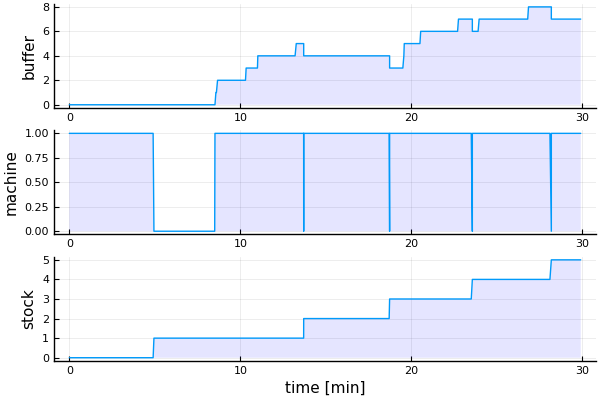

In [6]:
function trajectory_plot()
    p1 = plot(df.time, df.buffer, ylabel="buffer", fill=(0,0.1,:blue))
    p2 = plot(df.time, df.machine, ylabel="machine", fill=(0,0.1,:blue))
    p3 = plot(df.time, df.finished, xlabel="time [min]", ylabel="stock", fill=(0,0.1,:blue))
    plot(p1,p2,p3, layout=(3,1), legend=false)
end
trajectory_plot()

It seems that the queue increases over time. Thus we are interested in the behaviour of our model over a longer time. Therefore we switch off printing and continue the simulation for further 970 "minutes".

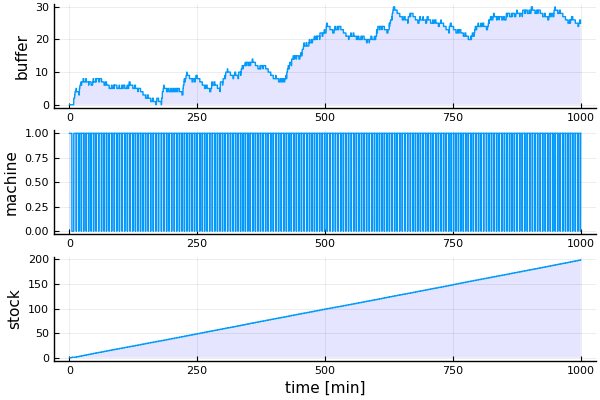

In [7]:
printing = false
run!(𝐶, 970)        # continue the simulation
trajectory_plot()

It seems that buffer size is increasing ever more over time. In the plot now machine load and stock aren't very instructive, so let's compare lead time $W$ and number of jobs in the system $L$ = buffer_size + machine_load:

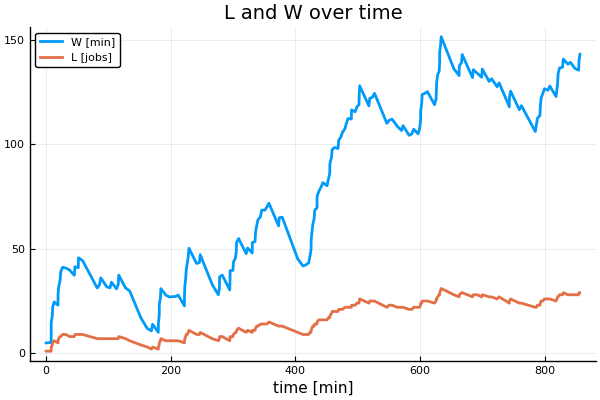

In [8]:
function WvsL() # get more instructive info from simulation run
    t = [j.t1 for j ∈ S]
    W = [j.t3 - j.t1 for j ∈ S]
    ts = [j.t3 - j.t2 for j ∈ S]
    subs = [i ∈ t for i ∈ df.time]
    L = (df.buffer + df.machine)[subs]
    l = df.machine[subs]
    DataFrame(time=t, load=l, W=W, L=L, ts=ts)
end
d = WvsL()
plot(d.time, d.W, label="W [min]", xlabel="time [min]", lw=2, legend=:topleft, title="L and W over time")
plot!(d.time, d.L, label="L [jobs]", lw=2)

Lead time $W$ and unfinished jobs $L$ are clearly increasing, the system is not stationary and gets jammed over time. Let's collect some stats:

In [9]:
collect_stats() =
    (Lm = mean(d.L), Wm = mean(d.W), η = mean(df.machine), tsm = mean(d.ts))
collect_stats()

(Lm = 16.21105527638191, Wm = 78.8196419189297, η = 0.9778719397363466, tsm = 5.003771234356064)

Server load of $\overline{η} ≈ 98\%$ is great, but the mean queue length $\overline{L}$ of 16 and mean lead time $\overline{W} ≈ 79$ min are way too long for a service time of $t_s ≈ 5$ min. So let's analyze the dependency of mean queue length $\overline{L}$ on server capacity $c$. For that we can manipulate the server capacity in the arrival function and collect the results in a table:

In [10]:
df1 = DataFrame(c=Float64[], Lm=Float64[], Wm=Float64[], η=Float64[], tsm=Float64[])
for c ∈ collect(0.97:0.01:1.7)
    global Q = Job[]   # input queue
    global S = Job[]   # stock
    global M = Machine(Idle(), 0)
    global df = DataFrame(time = Number[], buffer=Int[], machine=Int[], finished=Int[])
    global count = 1
    
    reset!(𝐶, unit=minute)                            # reset 𝐶
    sample_time!(𝐶, 1)                   # set sample rate to 1
    Simulate.sample!(𝐶, SimFunction(stats))   # register the stats() function for sampling
    
    Random.seed!(2019)
    arrive(5, 1/5, c)
    run!(𝐶, 1000)                        # run another simulation for 1000 "min"
    global d = WvsL()
    s = collect_stats()
    push!(df1, (c, s.Lm, s.Wm, s.η, s.tsm))
end

We can look at it in a scatter plot:

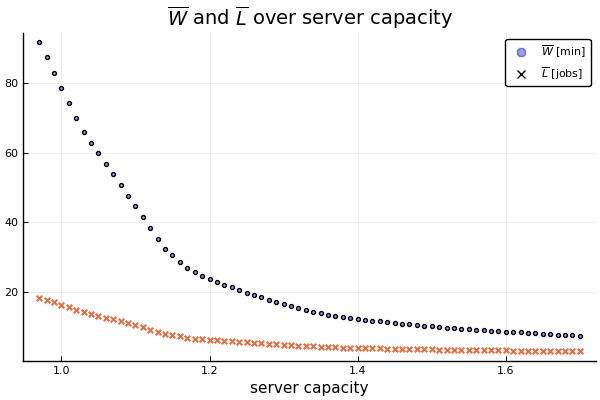

In [11]:
scatter(df1.c, df1.Wm, title=L"\overline{W}"*" and "*L"\overline{L}"*" over server capacity", 
    xlabel="server capacity", marker = (:o, 3, 0.4, :blue), label=L"\overline{W}"*" [min]")
scatter!(df1.c, df1.Lm, marker = (:x, 4), label=L"\overline{L}"*" [jobs]")

We need to increase server capacity much in order to avoid long queues and waiting times.

### How about Little's law?

$\overline{W}$ and $\overline{L}$ seem to be proportional. This is stated by [Little's law](https://en.wikipedia.org/wiki/Little%27s_law): 

$$L = \lambda\times W$$

for stationary systems with $\lambda$ = arrival rate. In our case $\lambda = t_a = 5$. Let's look at it:

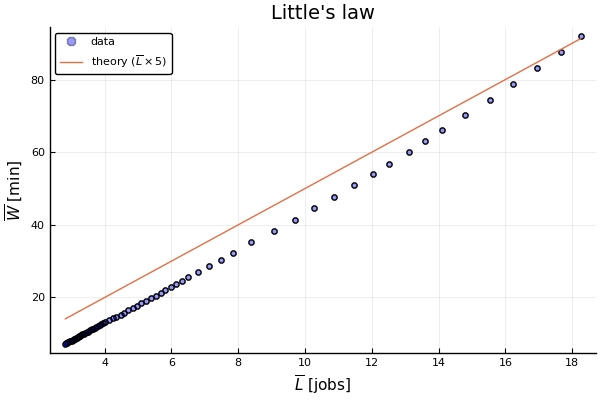

In [12]:
scatter(df1.Lm, df1.Wm, xlabel=L"\overline{L}"*" [jobs]", ylabel=L"\overline{W}"*" [min]", 
    marker = (:o, 4, 0.4, :blue), label="data", title="Little's law", legend=:topleft)
plot!(df1.Lm, df1.Lm*5, label="theory "*L"(\overline{L}\times 5)")

Data seems not quite to fit theory. Reason is that the system is not stationary. But for a first approach, Little's law seems not to be a bad one. In order to analyze stability and [stationarity](https://en.wikipedia.org/wiki/Stationary_process) and to improve, we could refine our analysis by taking only the second half of the simulation data or by doing more simulation runs and having some fun with `Sim.jl` ...

## 😄

pb, 2019-11-01